In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Used to create training and testing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import umap

/Users/yannick/opt/anaconda3/envs/test-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For testing
# "Words" contains the subset of words we make predictions for. 
words =  np.array(['hvad', 'ja', 'soed', 'mange', 'nej', 'nu', 'fordi', 'koebe', 'tid'])
label_map = {label:num for num, label in enumerate(words)}

# Base path leading to directory containing folders with videos for all signs defined in "words" array
base_path = "../extended_subset"

# Path for saving processed Data Arrays
proc_data_path = "../export_data/"

# Importing Data

In [3]:
X = np.load('../export_data/X_data.npy')
y = np.load('../export_data/y_data.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4*y.shape[1], stratify=y)

In [4]:
X_train.shape
y_test.shape

(36, 9)

In [28]:
FullDataset = np.array([features_2d.flatten() for features_2d in X])

# PCA (if needed) 

In [31]:
X_train2D = np.array([features_2d.flatten() for features_2d in X_train])
X_test2D = np.array([features_2d.flatten() for features_2d in X_test])

pca = PCA(n_components=10, svd_solver = 'full')
pca_train = pca.fit_transform(X_train2D)
pca_test = pca.fit_transform(X_test2D)
pca_full = pca.fit_transform(FullDataset)

# Dimension Reduction with Umap

In [37]:
umap_train = umap.UMAP(n_neighbors=12, min_dist=0.1, metric='minkowski').fit_transform(X_train2D)
umap_test = umap.UMAP(n_neighbors=12, min_dist=0.1, metric='minkowski').fit_transform(X_test2D)
umap_full = umap.UMAP(n_neighbors=12, min_dist=0.5, metric='minkowski').fit_transform(FullDataset)

# Visualizing Components

In [18]:
def visualize_labels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd','#5e4fa2'])
    y = referenceLabels

    colorind = np.where(y>0)[1]
    print(y.shape)
    plt.scatter(features[:, 0], features[:, 1], c = colorind, cmap = cmap_light)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.show()
  
    t = 0

(152, 9)


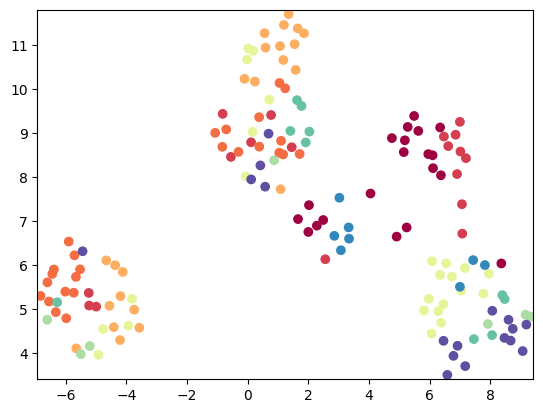

In [38]:
visualize_labels(umap_full, y)

(152, 9)


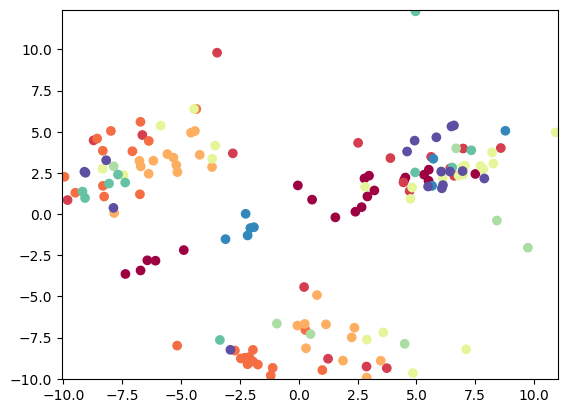

In [32]:
visualize_labels(pca_full, y)

# kNN Algorithm

In [33]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train2D, y_train)
y_pred = knn.predict(X_test2D)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6388888888888888


In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(pca_train, y_train)
y_pred = knn.predict(pca_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.1111111111111111


In [39]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(umap_train, y_train)
y_pred = knn.predict(umap_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.027777777777777776


In [40]:
k_values = [i for i in range (1,15)]
scores = []

for k in k_values:
    knn_test = KNeighborsClassifier(n_neighbors=k)
    knn_test.fit(X_train2D,y_train)
    score = accuracy = accuracy_score(y_test, knn_test.predict(X_test2D))
    scores.append(np.mean(score))

scores

[0.8055555555555556,
 0.4166666666666667,
 0.6388888888888888,
 0.3888888888888889,
 0.4444444444444444,
 0.3888888888888889,
 0.3888888888888889,
 0.25,
 0.3333333333333333,
 0.2222222222222222,
 0.2222222222222222,
 0.19444444444444445,
 0.25,
 0.1388888888888889]

# Random Forest

In [46]:
rForest = RandomForestClassifier(n_estimators=100)
rForest.fit(X_train2D, y_train)

RFy_pred = rForest.predict(X_test2D)
print("Accuracy:", accuracy_score(y_test, RFy_pred))

Accuracy: 0.3333333333333333


In [48]:
rForest = RandomForestClassifier(n_estimators=100)
rForest.fit(pca_train, y_train)

RFy_pred = rForest.predict(pca_test)
print("Accuracy:", accuracy_score(y_test, RFy_pred))

Accuracy: 0.027777777777777776
